In [1]:
import os
os.environ['GEMS_HOME'] = '/home/cogito/GEMS_python'

# MODIS 01

In [31]:
### Package Import
import sys
import os
base_dir = os.environ['GEMS_HOME']
project_path = os.path.join(base_dir, 'python-refactor')
sys.path.insert(0, project_path)
from Code.utils import matlab

import numpy as np
import glob
from osgeo import gdal
import subprocess
import tempfile

### Setting path
data_base_dir = os.path.join(project_path, 'Data')
raw_modis_path = os.path.join(data_base_dir, 'Raw', 'MODIS', 'MCD12Q1') 
path_mosaic = os.path.join(data_base_dir, 'Preprocessed_raw', 'MODIS', '01mosaic') #workspace = os.path.join(work_path, '01_mosaic')
tmpdirname = tempfile.TemporaryDirectory(dir=base_dir)  # will be deleted

flist = glob.glob(os.path.join(raw_modis_path, "*.hdf"))
flist.sort()
nfile = len(flist)

In [32]:
for k in range(0,nfile,14):
    flist_temp = flist[k:k+14]
    yr = os.path.basename(flist_temp[0])[9:13]
    
    input_files = [] 
    for m in range(0,14):
        fname = flist_temp[m]
        dst_dataset = os.path.join(tmpdirname.name, f"LC_{yr}_{m+1}.tif")
        
        gdal_dataset = gdal.Open(os.path.join(raw_modis_path, fname))
        src_dataset = gdal_dataset.GetSubDatasets()[0][0]
        subprocess.call(["gdal_translate", src_dataset, dst_dataset])
        input_files.append(dst_dataset)
    
    # Mosaic
    matlab.check_make_dir(path_mosaic) # debugging
    dst_fname = os.path.join(path_mosaic, f"EA_MCD12Q1_mosaic_{yr}.tif")
    pixel_type = 'Int16'
    in_nodata_val = "255"
    out_nodata_val = "-9999"
    compression = "COMPRESS=LZW"
    
    cmd = ["gdal_merge.py", "-n", in_nodata_val, "-a_nodata", out_nodata_val, "-ot", pixel_type]
    cmd += ["-co", compression]
    cmd += ["-o", dst_fname]
    cmd += input_files
    subprocess.call(cmd)
    
    tmpdirname.cleanup()
    print (os.path.basename(dst_fname))

2016


In [15]:
import rasterio as rio
from rasterio.plot import show

In [34]:
data = rio.open(dst_fname)

In [35]:
data.read(1)

array([[    3,     3,     8, ..., -9999, -9999, -9999],
       [    3,     3,     3, ..., -9999, -9999, -9999],
       [    3,     3,     3, ..., -9999, -9999, -9999],
       ...,
       [-9999, -9999, -9999, ...,    17,    17,    17],
       [-9999, -9999, -9999, ...,    17,    17,    17],
       [-9999, -9999, -9999, ...,    17,    17,    17]], dtype=int16)

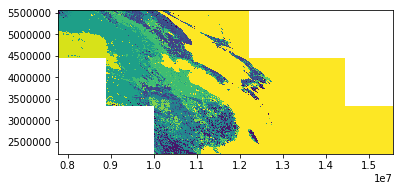

In [36]:
show(data)

In [37]:
data2 = rio.open('/home/cogito/GEMS_python/python-refactor/Data/Preprocessed_raw/MODIS/01mosaic/EA_MCD12Q1_mosaic_2016_arcpy.tif')

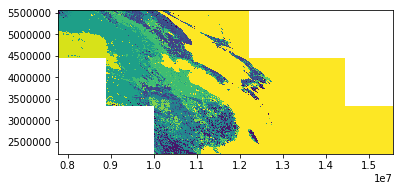

In [38]:
show(data2)

In [39]:
arr = data2.read(1)
arr[arr==255] = -9999

np.all(arr==data.read(1))

# MODIS 02

In [2]:
### Package Import
import sys
import os
base_dir = os.environ['GEMS_HOME']
project_path = os.path.join(base_dir, 'python-refactor')
sys.path.insert(0, project_path)
from Code.utils import matlab

import json
import glob
import time 
import tempfile
import rasterio as rio
from rasterio import features
from rasterio.mask import mask
from rasterio.warp import (
    calculate_default_transform, 
    aligned_target,
    reproject, 
    Resampling
)

In [3]:
### Setting path
data_base_dir = os.path.join(project_path, 'Data')
path_mosaic = os.path.join(data_base_dir, 'Preprocessed_raw', 'MODIS')
maskfile = os.path.join(data_base_dir, 'Raw', 'mask', 'r_rec_N50W110S20E150.tif')
with rio.open(maskfile) as masksrc:
    band = masksrc.read(1)
    maskarr = (band!=255)
    shapes = []
    for geometry, raster_value in features.shapes(band, mask=maskarr, transform=masksrc.transform):
        shapes.append(json.loads(json.dumps(geometry)))
    
flist = glob.glob(os.path.join(path_mosaic, '01mosaic', "*.tif"))
flist.sort()

In [4]:
for src_dataset in flist:
    last_num = os.path.basename(src_dataset)[-8:] # b 2016.tif
    print (src_dataset)
    
    matlab.check_make_dir(os.path.join(path_mosaic, '02prj_GCS_WGS84')) # debugging
    matlab.check_make_dir(os.path.join(path_mosaic, '03masked_N50W110S20E150')) # debugging
    
    dst_dataset02 = os.path.join(path_mosaic, '02prj_GCS_WGS84', f'GCS_EA_MCD12Q1_{last_num}') # c
    dst_dataset03 = os.path.join(path_mosaic, '03masked_N50W110S20E150', f'm_MODIS_LC_500m_{last_num}') # d

    dst_crs = 'EPSG:4326'
    resolution = 5.11542231032757E-03 # same with maskfile resolution
    with rio.open(src_dataset) as src:
        transform, width, height = calculate_default_transform(
                src.crs, dst_crs, 
                src.width, src.height, *src.bounds, 
                resolution=resolution)

        kwargs = src.meta.copy()
        kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height,
                'nodata':-9999,
                'compress':'LZW',
        })

        with rio.open(dst_dataset02, 'w', **kwargs) as dst02:
            for i in range(1, src.count+1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst02, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    src_nodata=-9999,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    dst_nodata=-9999,
                    dst_resolution=resolution,
                    resampling=Resampling.nearest,
                )
    with rio.open(dst_dataset02) as dst02:
        out_img, out_transform = mask(dataset=dst02, shapes=shapes, crop=True)
        out_meta = dst02.meta.copy()

        epsg_code = int(dst02.crs.data['init'][5:])
        out_meta.update({"height": out_img.shape[1],
                         "width": out_img.shape[2],
                         "transform": out_transform,
                         "crs": dst_crs}
                       )
        with rio.open(dst_dataset03, 'w', **out_meta) as dst03:
            dst03.write(out_img)
            
    print (os.path.basename(dst_dataset02))
    print (os.path.basename(dst_dataset03))

/home/cogito/GEMS_python/python-refactor/Data/Preprocessed_raw/MODIS/01mosaic/EA_MCD12Q1_mosaic_2016.tif
GCS_EA_MCD12Q1_2016.tif
m_MODIS_LC_500m_2016.tif


In [32]:
import rasterio as rio
from rasterio.plot import show

(1, 5865, 20626)
[[[-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  ...
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]
  [-9999 -9999 -9999 ... -9999 -9999 -9999]]]


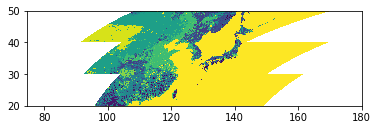

In [33]:
data = rio.open('/home/cogito/GEMS_python/python-refactor/Data/Preprocessed_raw/MODIS/02prj_GCS_WGS84/GCS_EA_MCD12Q1_2016.tif')
arr = data.read()
print (arr.shape)
print (arr)

show(data)

In [34]:
data.transform

Affine(0.00511542231032757, 0.0, 74.49244406578455,
       0.0, -0.00511542231032757, 49.99999999550685)

(1, 5866, 20627)
[[[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]]


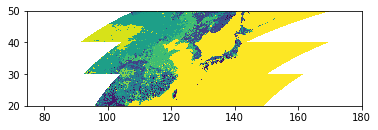

In [35]:
data2 = rio.open('GCS_EA_MCD12Q1_2016_arcpy.tif')

arr2 = data2.read()
print (arr2.shape)
print (arr2)

show(data2)

In [36]:
data2.transform

Affine(0.00511542231032757, 0.0, 74.48732864347429,
       0.0, -0.00511542231032757, 49.9999999955069)

In [37]:
data.transform

Affine(0.00511542231032757, 0.0, 74.49244406578455,
       0.0, -0.00511542231032757, 49.99999999550685)

Text(0.5, 1.0, 'Arcpy result')

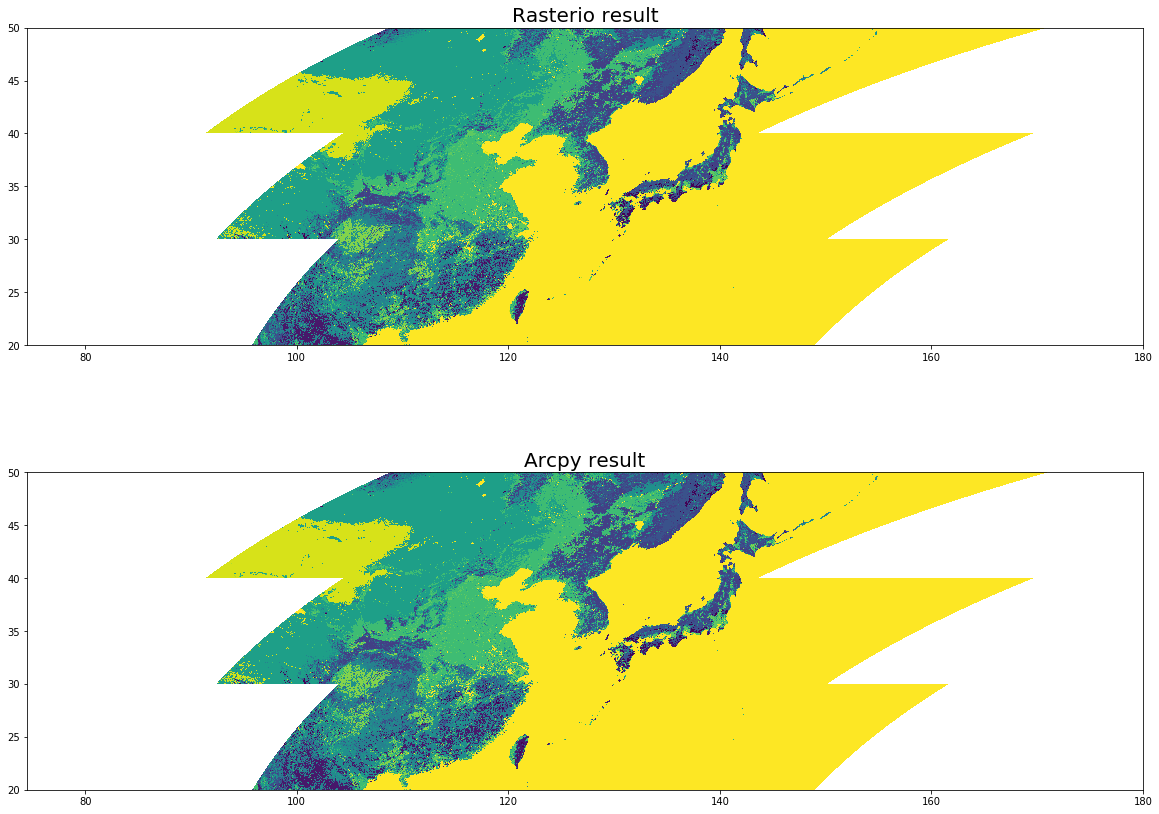

In [38]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,1, figsize=(20, 15))
show(data, ax=axs[0])
axs[0].set_title('Rasterio result', fontsize=20)
show(data2, ax=axs[1])
axs[1].set_title('Arcpy result', fontsize=20)

In [39]:
import numpy as np

In [40]:
arr2[arr2==255] = -9999

np.all(arr==arr2)

/home/cogito/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


False

In [74]:
data4 = rio.open('m_MODIS_LC_500m_2016_arcpy.tif')

In [75]:
np.unique(data4.read(1))

array([-128,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17], dtype=int8)

In [42]:
data4.shape

(5865, 7820)

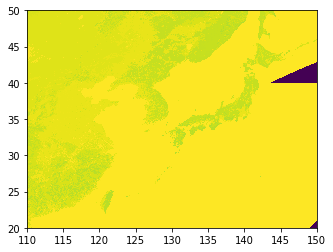

In [43]:
show(data4)

In [44]:
arr4 = data4.read(1)

In [45]:
arr4

array([[   8,    8,    8, ...,   17,   17,   17],
       [   8,    8,    8, ...,   17,   17,   17],
       [   8,    8,    8, ...,   17,   17,   17],
       ...,
       [  17,   17,   17, ..., -128, -128, -128],
       [  17,   17,   17, ..., -128, -128, -128],
       [  17,   17,   17, ..., -128, -128, -128]], dtype=int8)

In [46]:
np.unique(arr4)

array([-128,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17], dtype=int8)

In [55]:
arr4[arr4==-128] = -9999

In [56]:
np.unique(arr4)

array([-15,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17], dtype=int8)

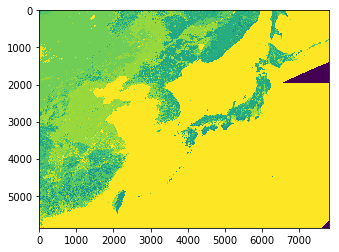

In [57]:
show(arr4)

In [76]:
data3 = rio.open(dst_dataset03)

In [77]:
np.unique(data3.read(1))

array([-9999,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17],
      dtype=int16)

In [49]:
data3.shape

(5865, 7820)

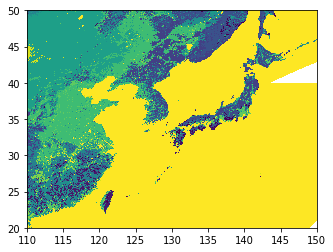

In [50]:
show(data3)

In [51]:
arr3 = data3.read(1)

In [52]:
np.unique(arr3)

array([-9999,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17],
      dtype=int16)

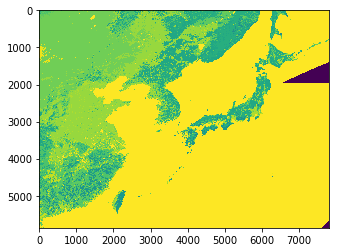

In [53]:
show(arr3.astype('int8'))

In [54]:
arr3.astype('int8') == arr4

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [30]:
100.0*np.where(arr3.astype('int8')!=arr4)[0].shape[0]/arr3.flatten().shape[0]

0.030629487422679513

In [31]:
arr3.astype('int8')

array([[  8,   8,   8, ...,  17,  17,  17],
       [  8,   8,   8, ...,  17,  17,  17],
       [  8,   8,   8, ...,  17,  17,  17],
       ...,
       [ 17,  17,  17, ..., -15, -15, -15],
       [ 17,  17,  17, ..., -15, -15, -15],
       [ 17,  17,  17, ..., -15, -15, -15]], dtype=int8)

In [131]:
data3.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -9999.0,
 'width': 7820,
 'height': 5865,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00511542231032757, 0.0, 109.9985903217682,
        0.0, -0.00511542231032757, 49.99999999550685)}

# MODIS 03

In [58]:
data = rio.open('reclass_MODIS_LC_500m_EA_2016.tif')

In [63]:
data.meta

{'driver': 'GTiff',
 'dtype': 'int8',
 'nodata': -128.0,
 'width': 7820,
 'height': 5865,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.005115422310327571, 0.0, 109.9985903217682,
        0.0, -0.005115422310327571, 49.9999999955069)}

In [61]:
np.unique(data.read(1))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int8)

In [60]:
data.read(1)

array([[ 3,  3,  3, ..., 10, 10, 10],
       [ 3,  3,  3, ..., 10, 10, 10],
       [ 3,  3,  3, ..., 10, 10, 10],
       ...,
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10],
       [10, 10, 10, ..., 10, 10, 10]], dtype=int8)

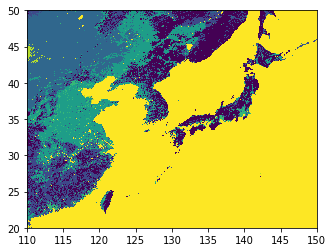

In [59]:
show(data)

In [137]:
data2 = rio.open('/home/cogito/GEMS_python/python-refactor/Data/Preprocessed_raw/MODIS/01_reclassified/reclass_MODIS_LC_500m_EA_2016.tif')

In [138]:
np.unique(data2.read(1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int8)

In [139]:
data.meta

{'driver': 'GTiff',
 'dtype': 'int8',
 'nodata': -128.0,
 'width': 7820,
 'height': 5865,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.005115422310327571, 0.0, 109.9985903217682,
        0.0, -0.005115422310327571, 49.9999999955069)}

In [140]:
data2.read(1)

array([[ 3,  3,  3, ..., 10, 10, 10],
       [ 3,  3,  3, ..., 10, 10, 10],
       [ 3,  3,  3, ..., 10, 10, 10],
       ...,
       [10, 10, 10, ...,  0,  0,  0],
       [10, 10, 10, ...,  0,  0,  0],
       [10, 10, 10, ...,  0,  0,  0]], dtype=int8)

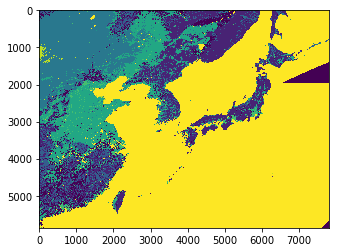

In [141]:
show(data2.read(1).astype('int8'))

In [142]:
data.read(1)==data2.read(1)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [145]:
band = rio.open('MODIS_LC_500m_EA_forest_2016.tif')

In [147]:
np.unique(band.read(1))

array([0, 1], dtype=uint8)

In [148]:
band.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 3.0,
 'width': 7820,
 'height': 5865,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.005115422310327571, 0.0, 109.9985903217682,
        0.0, -0.005115422310327571, 49.9999999955069)}

In [150]:
band2 = rio.open('/home/cogito/GEMS_python/python-refactor/Data/Preprocessed_raw/MODIS/02_LC_binary/2016/MODIS_LC_500m_EA_forest_2016.tif')

In [157]:
band.read(1)==band2.read(1)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

# MODIS 04

In [2]:
### Package Import
import sys
import os
base_dir = os.environ['GEMS_HOME']
project_path = os.path.join(base_dir, 'python-refactor')
sys.path.insert(0, project_path)
from Code.utils import matlab

from numba import njit
import numpy as np
from scipy.ndimage.filters import generic_filter as gf
import rasterstats
import rasterio as rio
import glob
import time 

In [3]:
data_base_dir = os.path.join(project_path, 'Data')
path_modis = os.path.join(data_base_dir, 'Preprocessed_raw', 'MODIS')
class_name = ["forest","shrub","savannas","grass","wetland","crop","urban","snow","barren","water"]

In [4]:
radius = 6
y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
mask = x**2 + y**2 <= radius**2

In [48]:
@njit
def njit_mean(data):
    return np.mean(data)

In [6]:
yr = 2016
col = class_name[0]

In [7]:
input_file = os.path.join(path_modis, '02_LC_binary', str(yr), f"MODIS_LC_500m_EA_{col}_{yr}.tif")
in_raster = rio.open(input_file)

In [55]:
band = in_raster.read(1).astype('float64')

In [49]:
circular_mean = gf(band, njit_mean, footprint=mask)

In [57]:
in_raster.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 7820,
 'height': 5865,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00511542231032757, 0.0, 109.9985903217682,
        0.0, -0.00511542231032757, 49.99999999550685)}

In [29]:
import rasterio as rio
from rasterio.plot import show

In [30]:
out_raster = os.path.join(path_modis, "03_LC_ratio", str(yr), f"EA_{col}_ratio_r6_500m_{yr}.tif")

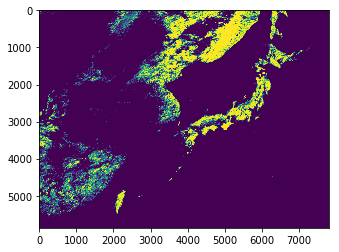

In [54]:
show(circular_mean2)

In [22]:
data2 = rio.open(f'EA_{col}_ratio_r6_500m_{yr}.tif')

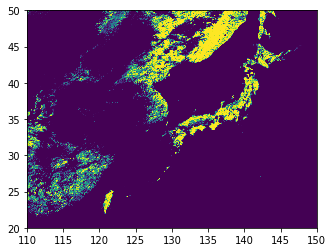

In [24]:
show(data2)

# MODIS 05

In [12]:
import sys
import os
base_dir = os.environ['GEMS_HOME']
project_path = os.path.join(base_dir, 'python-refactor')
sys.path.insert(0, project_path)
from Code.utils import matlab

import tempfile
import glob

In [13]:
data_base_dir = os.path.join(project_path, 'Data')
path_modis = os.path.join(data_base_dir, 'Preprocessed_raw', 'MODIS')
class_name = ["forest","shrub","savannas","grass","wetland","crop","urban","snow","barren","water"]

tmpdirname = tempfile.TemporaryDirectory(dir=base_dir)  # will be deleted

In [9]:
path_read = os.path.join(data_base_dir, 'Raw', 'MODIS', 'MYD13A2')
path_write = os.path.join(data_base_dir, 'Preprocessed_raw', 'MODIS', 'MYD13A2')

YEARS = [2016]
for yr in YEARS: 
    print(yr)
    
    flist = glob.glob(os.path.join(path_read, str(yr), "*.hdf"))
    flist.sort()
    nfile = len(flist)

    path_mosaic = os.path.join(path_write, "01mosaic", str(yr))
    for k in range(0,nfile,14): #for k in range(56,nfile,14):
        flist_temp = flist[k:k+14]
        doy = os.path.basename(flist_temp[0])[14:17]
        print (f'doy: {doy}')
        
        input_files = []
        for m in range(0,14):
            temp = gdal.Open(flist_temp[m])
            src_dataset = temp.GetSubDatasets()[0][0]
            dst_dataset = os.path.join(tmpdirname, f"NDVI_{doy}_{m+1}.tif")
            del temp
            
            subprocess.call(["gdal_translate", src_dataset, dst_dataset])
            input_files.append(dst_dataset)
            
        
        fname = f"MYD13A2_{j}_{doy}.tif"
        out_fname = os.path.join(path_mosaic, fnam)
        cmd = ["gdal_merge.py", "-o", out_fname, "-ot", "Int16"]
        cmd.append(tiles)
        subprocess.call(cmd)
        for m in range(0,14):
            #arcpy.Delete_management(""+path+"\\NDVI_"+str(doy)+"_"+str(m+1)+".tif")
            os.remove(os.path.join(path, f"NDVI_{doy}_{m+1}.tif"))
        print(doy)
    break

2016
